## 1. Interploate the missing dates.

The following dates are missing in the dataset:



In [ ]:
import pandas as pd

# Load the CSV file
basin_id = "05535070"
file_path = f'c:/Users/ybrot/Desktop/course/UROP/GAGEii_modeling/US_climate_discharge_data/{basin_id}.csv'
df = pd.read_csv(file_path)
df.rename(columns={"Date": "date"}, inplace=True)

# Ensure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Set the 'date' column as the index
df.set_index('date', inplace=True)

# Generate a date range from the minimum to the maximum date in the dataframe
date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

# Reindex the dataframe to this date range
df_reindexed = df.reindex(date_range)

# Find missing dates
missing_dates = df_reindexed[df_reindexed.isnull().any(axis=1)].index

# Print missing dates
print("Missing dates:")
for date in missing_dates:
    print(date.strftime('%Y-%m-%d'))

# Check frequency
frequency = pd.infer_freq(df.index)
print(f"Detected frequency: {frequency}")

Missing dates:
1980-12-31
1984-12-31
1988-12-31
1992-12-31
1996-12-31
2000-12-31
2004-12-31
2008-12-31
2012-12-31
2016-12-31
2020-12-31
Detected frequency: None


Therefore, we will interpolate the missing dates in the dataset.

In [ ]:
import os
import pandas as pd
from tqdm import tqdm

# Define the input and output folders
input_folder = 'climate_discharge_data'
output_folder = 'data/csv_files'
basins_list_file = 'basin_list/basin_list_complete.txt'

# Read the list of basin IDs
with open(basins_list_file, 'r') as file:
    basin_ids = file.read().splitlines()

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Function to interpolate missing dates
def interpolate_missing_dates(df, missing_dates):
    # Ensure the 'date' column is in datetime format
    df.rename(columns={"Date": "date"}, inplace=True)
    df['date'] = pd.to_datetime(df['date'])
    # Set the 'date' column as the index
    df.set_index('date', inplace=True)
    # Generate a complete date range from the minimum to the maximum date in the dataframe
    date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
    # Reindex the dataframe to this date range
    df_reindexed = df.reindex(date_range)
    # Interpolate missing values
    df_interpolated = df_reindexed.interpolate(method='time')
    return df_interpolated

# Process each CSV file
for basin_id in tqdm(basin_ids):
    input_file = os.path.join(input_folder, f'{basin_id}.csv')
    output_file = os.path.join(output_folder, f'{basin_id}.csv')
    
    # Read the CSV file
    df = pd.read_csv(input_file)
    
    # Interpolate missing dates
    missing_dates = [
        '1980-12-31', '1984-12-31', '1988-12-31', '1992-12-31', 
        '1996-12-31', '2000-12-31', '2004-12-31', '2008-12-31', 
        '2012-12-31', '2016-12-31', '2020-12-31'
    ]
    df_interpolated = interpolate_missing_dates(df, missing_dates)
    
    # Reset the index to have 'date' as a column again
    df_interpolated.reset_index(inplace=True)
    df_interpolated.rename(columns={'index': 'date'}, inplace=True)
    
    # Convert all negative values in the "discharge" column to NaN
    df_interpolated['discharge'] = df_interpolated['discharge'].apply(lambda x: x if x >= 0 else pd.NA)
    
    # If the basin_id does not start with "02", divide the values in the "discharge" column by 35.315
    # Basins not starting with "02" are US stations, using an undesired unit - cubic ft / s
    if not basin_id.startswith("02"):
        df_interpolated['discharge'] = df_interpolated['discharge'] / 35.315
    
    # Write the output CSV file
    df_interpolated.to_csv(output_file, index=False)

print("Interpolation and file writing completed.")

100%|██████████| 976/976 [03:33<00:00,  4.58it/s]

Interpolation and file writing completed.


## 2. Check the data for missing dates.

In [ ]:
import os
import pandas as pd

# Define the directory containing the imputed CSV files
directory = 'data/csv_files'

# Initialize a flag to check if all files meet the condition
all_files_valid = True
non_satisfying_files = []

# Get the list of all file names in the directory
basin_ids = [f.split('.')[0] for f in os.listdir(directory) if f.endswith('.csv')]

# Iterate over each file in the directory
for basin_id in tqdm(basin_ids):
    
    file_path = f'data/csv_files/{basin_id}.csv'
    file_name = f'{basin_id}.csv'
        
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    df.rename(columns={"Date": "date"}, inplace=True)
    # Ensure the 'date' column is in datetime format and set as index
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df.set_index('date', inplace=True)
    
    # Create a full date range and check for missing dates
    full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
    missing_dates = full_range.difference(df.index)
    
    # Check if the frequency of missing dates is 'D'
    if missing_dates.freq != 'D':
        # print(f"File {file_name} does not meet the condition.")
        # print(f"Frequency of missing dates: {missing_dates.freq}")
        all_files_valid = False
        non_satisfying_files.append(file_name)
        

if all_files_valid:
    print("All files meet the condition.")
else:
    print("Some files do not meet the condition.")

100%|██████████| 976/976 [00:16<00:00, 60.14it/s]

All files meet the condition.


## 3. Convert the data to a time series. (NetCDF)

In [13]:
from resources.file_conversion import DataFrame_to_CDF
from tqdm import tqdm
import pandas as pd
import os

def convert_csv_to_cdf(input_folder: str, output_folder: str):
    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)
    
    # Get all CSV files in the input folder
    csv_files = [f for f in os.listdir(input_folder) if f.endswith('.csv')]
    
    for csv_file in tqdm(csv_files):
        # Construct the file path for the CSV file
        csv_file_path = os.path.join(input_folder, csv_file)
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(csv_file_path, index_col='date')
        df.index = pd.to_datetime(df.index)
        
        # Convert the DataFrame to a CDF file
        basin_id = os.path.splitext(csv_file)[0]
        DataFrame_to_CDF(df, output_folder, basin_id)


In [15]:
input_folder = './data/z-standardized_csv_files'
output_folder = './data/time_series'
convert_csv_to_cdf(input_folder, output_folder)

100%|██████████| 976/976 [01:15<00:00, 12.97it/s]


## 4. Data Normalization

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Define the directory containing the CSV files
data_folder = 'data/csv_files'

# Initialize an empty list to store the data
data_list = []

# Iterate over all CSV files in the directory
for file_name in tqdm(os.listdir(data_folder)):
    if file_name.endswith('.csv'):
        file_path = os.path.join(data_folder, file_name)
        df = pd.read_csv(file_path, index_col='date')
        data_list.append(df)

# Concatenate all data into a single DataFrame
combined_df = pd.concat(data_list)



100%|██████████| 976/976 [00:22<00:00, 43.25it/s]


In [4]:
combined_df.info

<bound method DataFrame.info of             discharge       dayl       prcp       srad        swe      tmax  \
date                                                                          
1980-01-01   2.320000  29643.209   0.000000  134.00153  82.957115 -6.852998   
1980-01-02   2.320000  29701.252   0.000000  161.91626  82.957115 -9.147027   
1980-01-03   2.320000  29764.002   0.000000  181.16530  82.957115 -8.942873   
1980-01-04   2.350000  29831.414   3.934299  109.06445  86.891470 -7.289824   
1980-01-05   2.350000  29903.428  10.268102   75.10631  97.159590 -6.403406   
...               ...        ...        ...        ...        ...       ...   
2023-12-27   0.818349  32141.787   0.000000  182.31155   0.000000  5.225181   
2023-12-28   0.654113  32168.037   7.673132   86.21674   0.000000  5.366386   
2023-12-29   1.446977  32198.127   0.034699  136.42868   0.000000  4.473735   
2023-12-30   0.959932  32232.021   0.000000  176.49336   0.000000  3.466988   
2023-12-31   0.65128

8it [10:12, 76.56s/it]


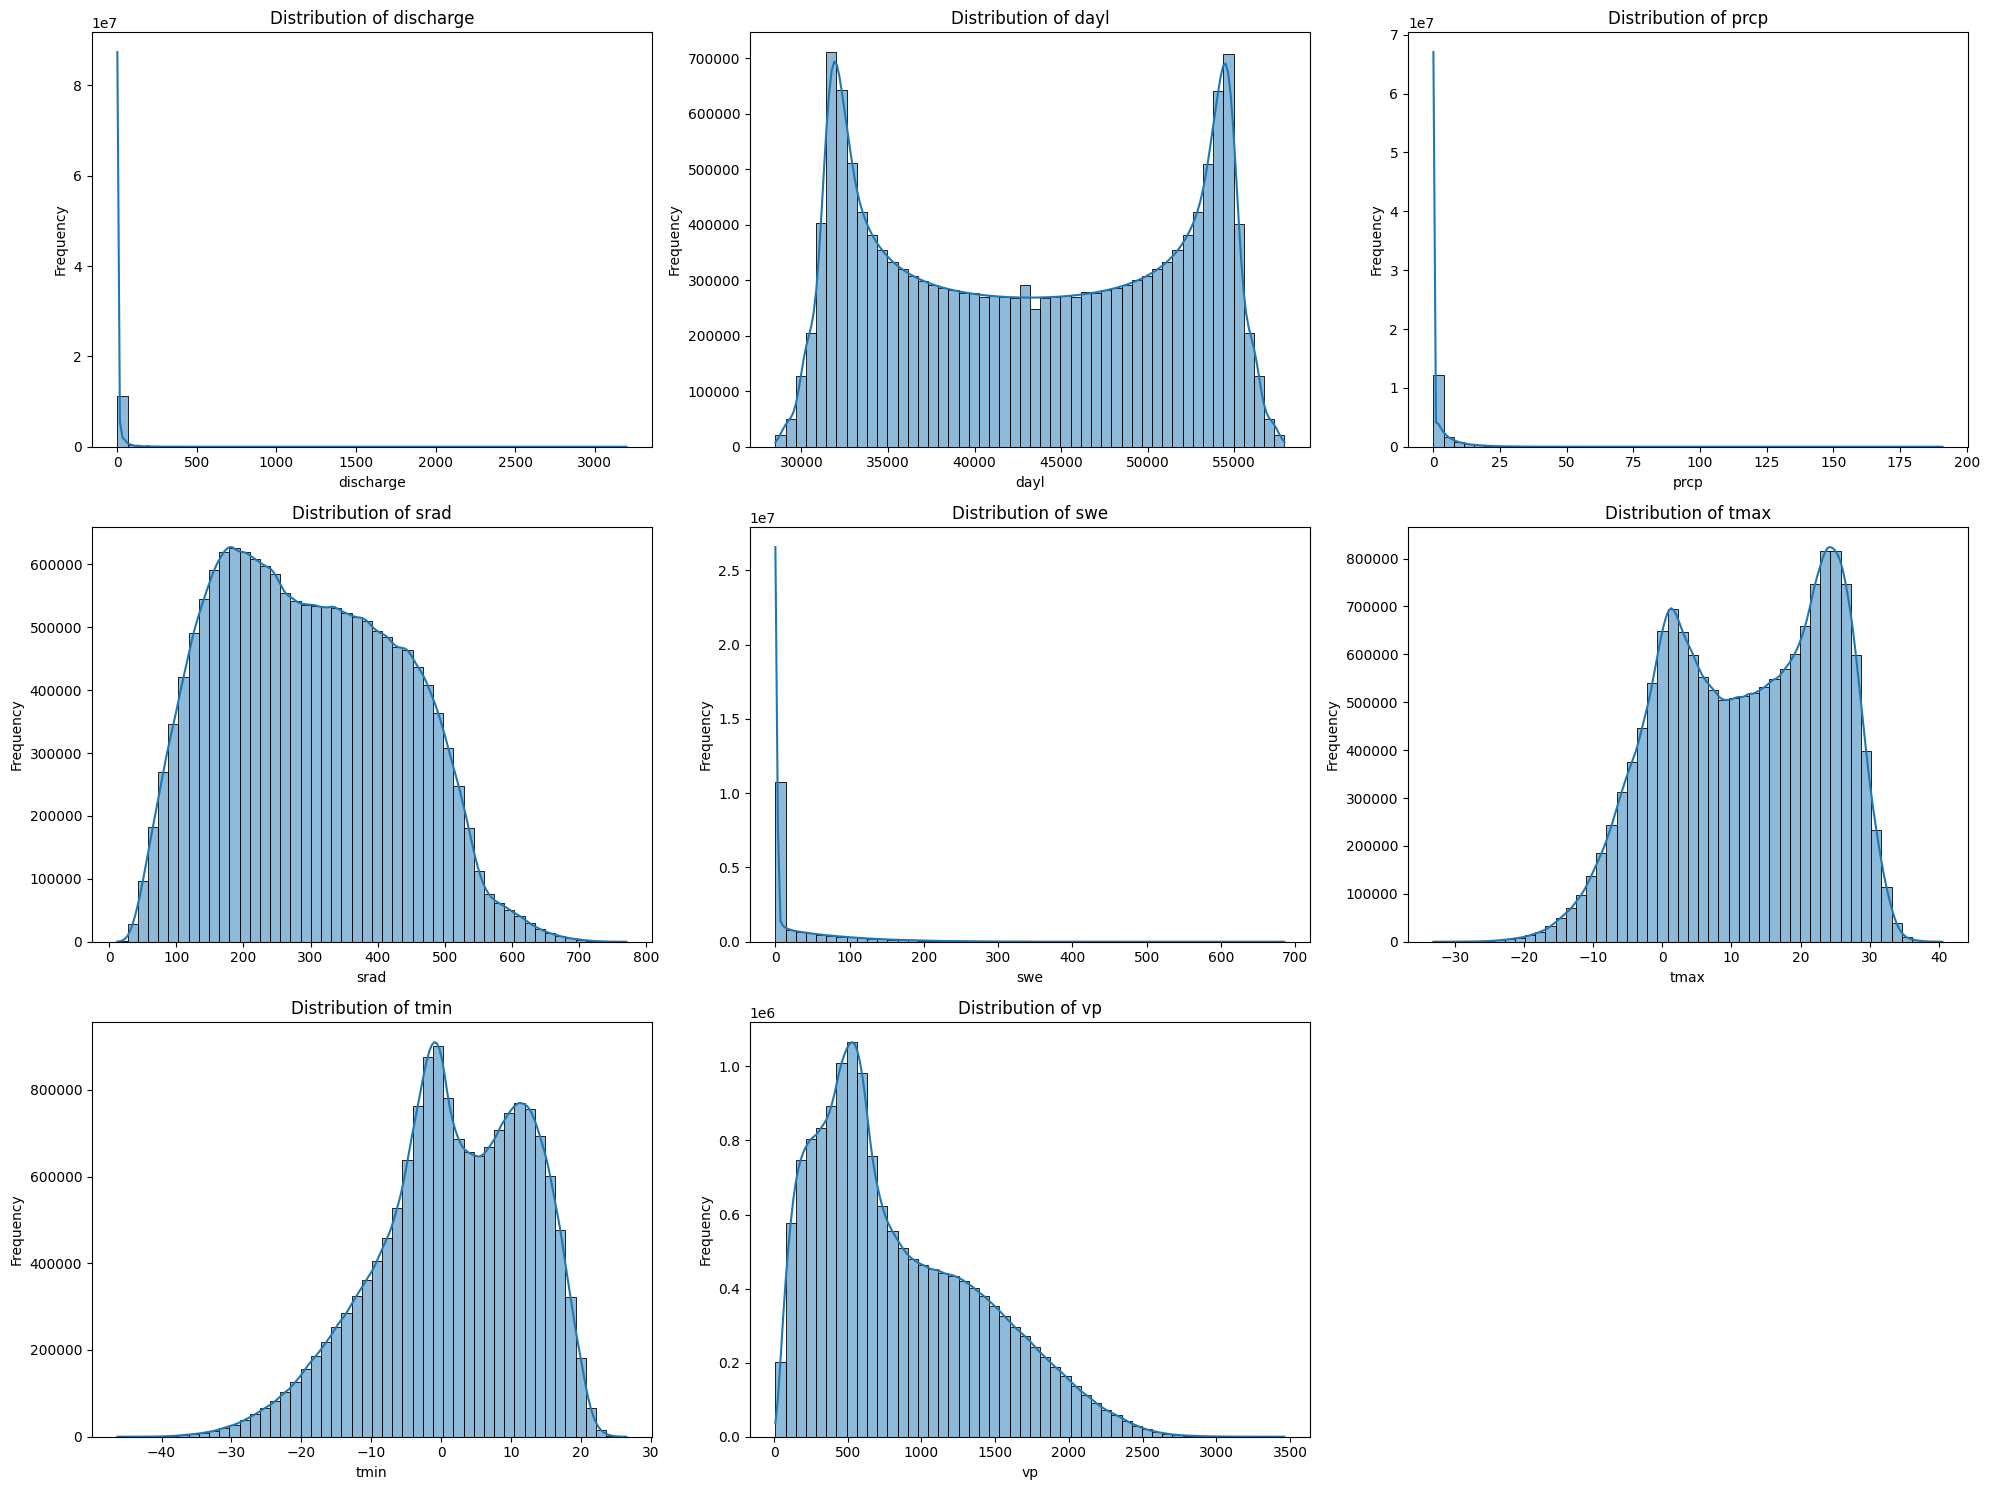

In [4]:
# Plot the distribution of each variable
variables = ['discharge', 'dayl', 'prcp', 'srad', 'swe', 'tmax', 'tmin', 'vp']

plt.figure(figsize=(20, 15))
for i, variable in tqdm(enumerate(variables, 1)):
    plt.subplot(3, 3, i)
    sns.histplot(combined_df[variable].dropna(), bins=50, kde=True)
    plt.xlabel(variable)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {variable}')

plt.tight_layout()
plt.show()

### Log Transformation

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

# Define the directory containing the CSV files
data_folder = '../metadata/csv_filtered'

# Initialize an empty list to store the data
data_list = []

# Iterate over all CSV files in the directory
for file_name in tqdm(os.listdir(data_folder)):
    if file_name.endswith('.csv'):
        file_path = os.path.join(data_folder, file_name)
        df = pd.read_csv(file_path, index_col='date')
        
        # Convert the index to datetime
        df.index = pd.to_datetime(df.index)
        
        # Filter the data to only include dates less than or equal to '31/12/2010'
        df = df[df.index <= '2010-12-31']
        
        # Add a very small value to "discharge", "prcp", and "swe" variables
        df['discharge'] += 1e-6
        df['prcp'] += 1e-6
        df['swe'] += 1e-6
        
        # Apply log transformation
        df['discharge'] = df['discharge'].apply(lambda x: np.log(x))
        df['prcp'] = df['prcp'].apply(lambda x: np.log(x))
        df['swe'] = df['swe'].apply(lambda x: np.log(x))
        
        data_list.append(df)

# Concatenate all data into a single DataFrame
combined_df = pd.concat(data_list)

# Collect mean and variance values for each variable
mean_variance_values = {}
variables = ['discharge', 'dayl', 'prcp', 'srad', 'swe', 'tmax', 'tmin', 'vp']

for variable in variables:
    mean_variance_values[variable] = {
        'mean': combined_df[variable].mean(),
        'variance': combined_df[variable].var()
    }

# Export the mean and variance values to a text file
with open('mean_variance_values.txt', 'w') as file:
    for variable, values in mean_variance_values.items():
        file.write(f"{variable}:\n")
        file.write(f"  mean: {values['mean']}\n")
        file.write(f"  variance: {values['variance']}\n")

100%|██████████| 976/976 [00:35<00:00, 27.23it/s]
C:\Users\ybrot\AppData\Local\Temp\ipykernel_38044\2811140934.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(data_list)


3it [02:19, 46.53s/it]


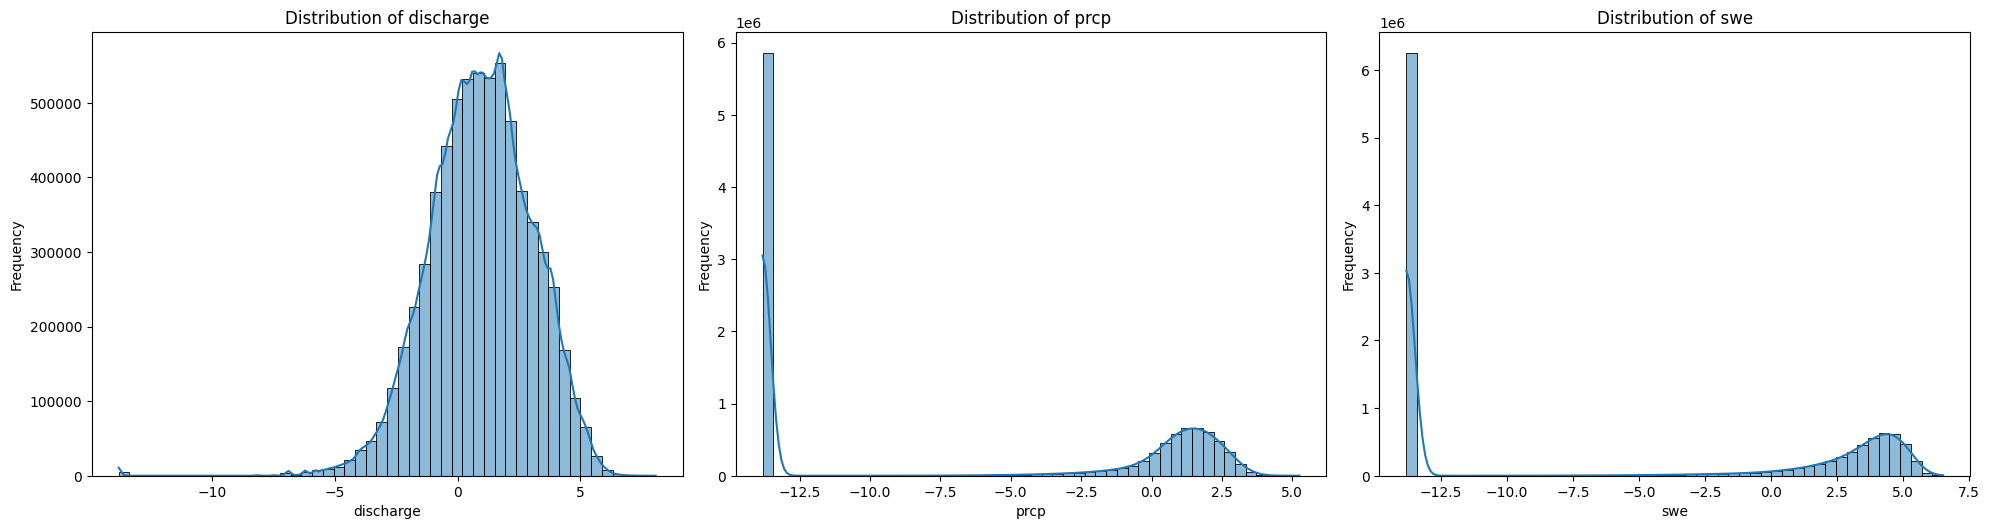

In [3]:
variables = ['discharge', 'prcp',  'swe']

plt.figure(figsize=(20, 15))
for i, variable in tqdm(enumerate(variables, 1)):
    plt.subplot(3, 3, i)
    sns.histplot(combined_df[variable].dropna(), bins=50, kde=True)
    plt.xlabel(variable)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {variable}')

plt.tight_layout()
plt.show()

In [6]:
discharge_series = pd.Series(combined_df['discharge'])
len(discharge_series)

11039925

## Apply Transformation

In [11]:
# minmax standardization

import os
import pandas as pd
import numpy as np
from tqdm import tqdm

# Define the directories
data_folder = 'data/csv_files'
output_folder = 'data/processed_csv_files'

# Ensure the output directory exists
os.makedirs(output_folder, exist_ok=True)

# Read the min and max values from the text file
min_max_values = {}
with open('min_max_values.txt', 'r') as file:
    lines = file.readlines()
    for i in range(0, len(lines), 3):
        variable = lines[i].strip().replace(':', '')
        min_value = float(lines[i+1].split(': ')[1])
        max_value = float(lines[i+2].split(': ')[1])
        min_max_values[variable] = {'min': min_value, 'max': max_value}

# Iterate over all CSV files in the directory
for file_name in tqdm(os.listdir(data_folder)):
    if file_name.endswith('.csv'):
        file_path = os.path.join(data_folder, file_name)
        df = pd.read_csv(file_path, index_col='date')
        
        # Add a very small value to "discharge", "prcp", and "swe" variables
        df['discharge'] += 1e-6
        df['prcp'] += 1e-6
        df['swe'] += 1e-6
        
        # Apply log transformation
        df['discharge'] = df['discharge'].apply(lambda x: np.log(x))
        df['prcp'] = df['prcp'].apply(lambda x: np.log(x))
        df['swe'] = df['swe'].apply(lambda x: np.log(x))
        
        # Apply min-max standardization
        for variable in df.columns:
            min_value = min_max_values[variable]['min']
            max_value = min_max_values[variable]['max']
            df[variable] = (df[variable] - min_value) / (max_value - min_value)
        
        # Save the processed file to the output folder
        output_file_path = os.path.join(output_folder, file_name)
        df.to_csv(output_file_path)

100%|██████████| 976/976 [01:56<00:00,  8.36it/s]


In [13]:
# z-score standardization

import os
import pandas as pd
import numpy as np
from tqdm import tqdm


# Define the directories
data_folder = 'data/csv_files'
output_folder = 'data/z-standardized_csv_files'

# Ensure the output directory exists
os.makedirs(output_folder, exist_ok=True)

# Read the mean and variance values from the text file
mean_variance_values = {}
with open('mean_variance_values.txt', 'r') as file:
    lines = file.readlines()
    for i in range(0, len(lines), 3):
        variable = lines[i].strip().replace(':', '')
        mean_value = float(lines[i+1].split(': ')[1])
        variance_value = float(lines[i+2].split(': ')[1])
        mean_variance_values[variable] = {'mean': mean_value, 'variance': variance_value}

# Iterate over all CSV files in the directory
for file_name in tqdm(os.listdir(data_folder)):
    if file_name.endswith('.csv'):
        file_path = os.path.join(data_folder, file_name)
        df = pd.read_csv(file_path, index_col='date')
        
        # Add a very small value to "discharge", "prcp", and "swe" variables
        df['discharge'] += 1e-6
        df['prcp'] += 1e-6
        df['swe'] += 1e-6
        
        # Apply log transformation
        df['discharge'] = df['discharge'].apply(lambda x: np.log(x))
        df['prcp'] = df['prcp'].apply(lambda x: np.log(x))
        df['swe'] = df['swe'].apply(lambda x: np.log(x))
        
        # Apply z-score standardization
        for variable in df.columns:
            mean_value = mean_variance_values[variable]['mean']
            variance_value = mean_variance_values[variable]['variance']
            df[variable] = (df[variable] - mean_value) / np.sqrt(variance_value)
        
        # Save the processed file to the output folder
        output_file_path = os.path.join(output_folder, file_name)
        df.to_csv(output_file_path)

100%|██████████| 976/976 [01:56<00:00,  8.35it/s]


In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Define the directory containing the CSV files
data_folder = 'data/processed_csv_files'

# Initialize an empty list to store the data
data_list = []

# Iterate over all CSV files in the directory
for file_name in tqdm(os.listdir(data_folder)):
    if file_name.endswith('.csv'):
        file_path = os.path.join(data_folder, file_name)
        df = pd.read_csv(file_path, index_col='date')
        data_list.append(df)

# Concatenate all data into a single DataFrame
combined_df = pd.concat(data_list)



100%|██████████| 976/976 [00:20<00:00, 48.05it/s]


8it [08:06, 60.82s/it]


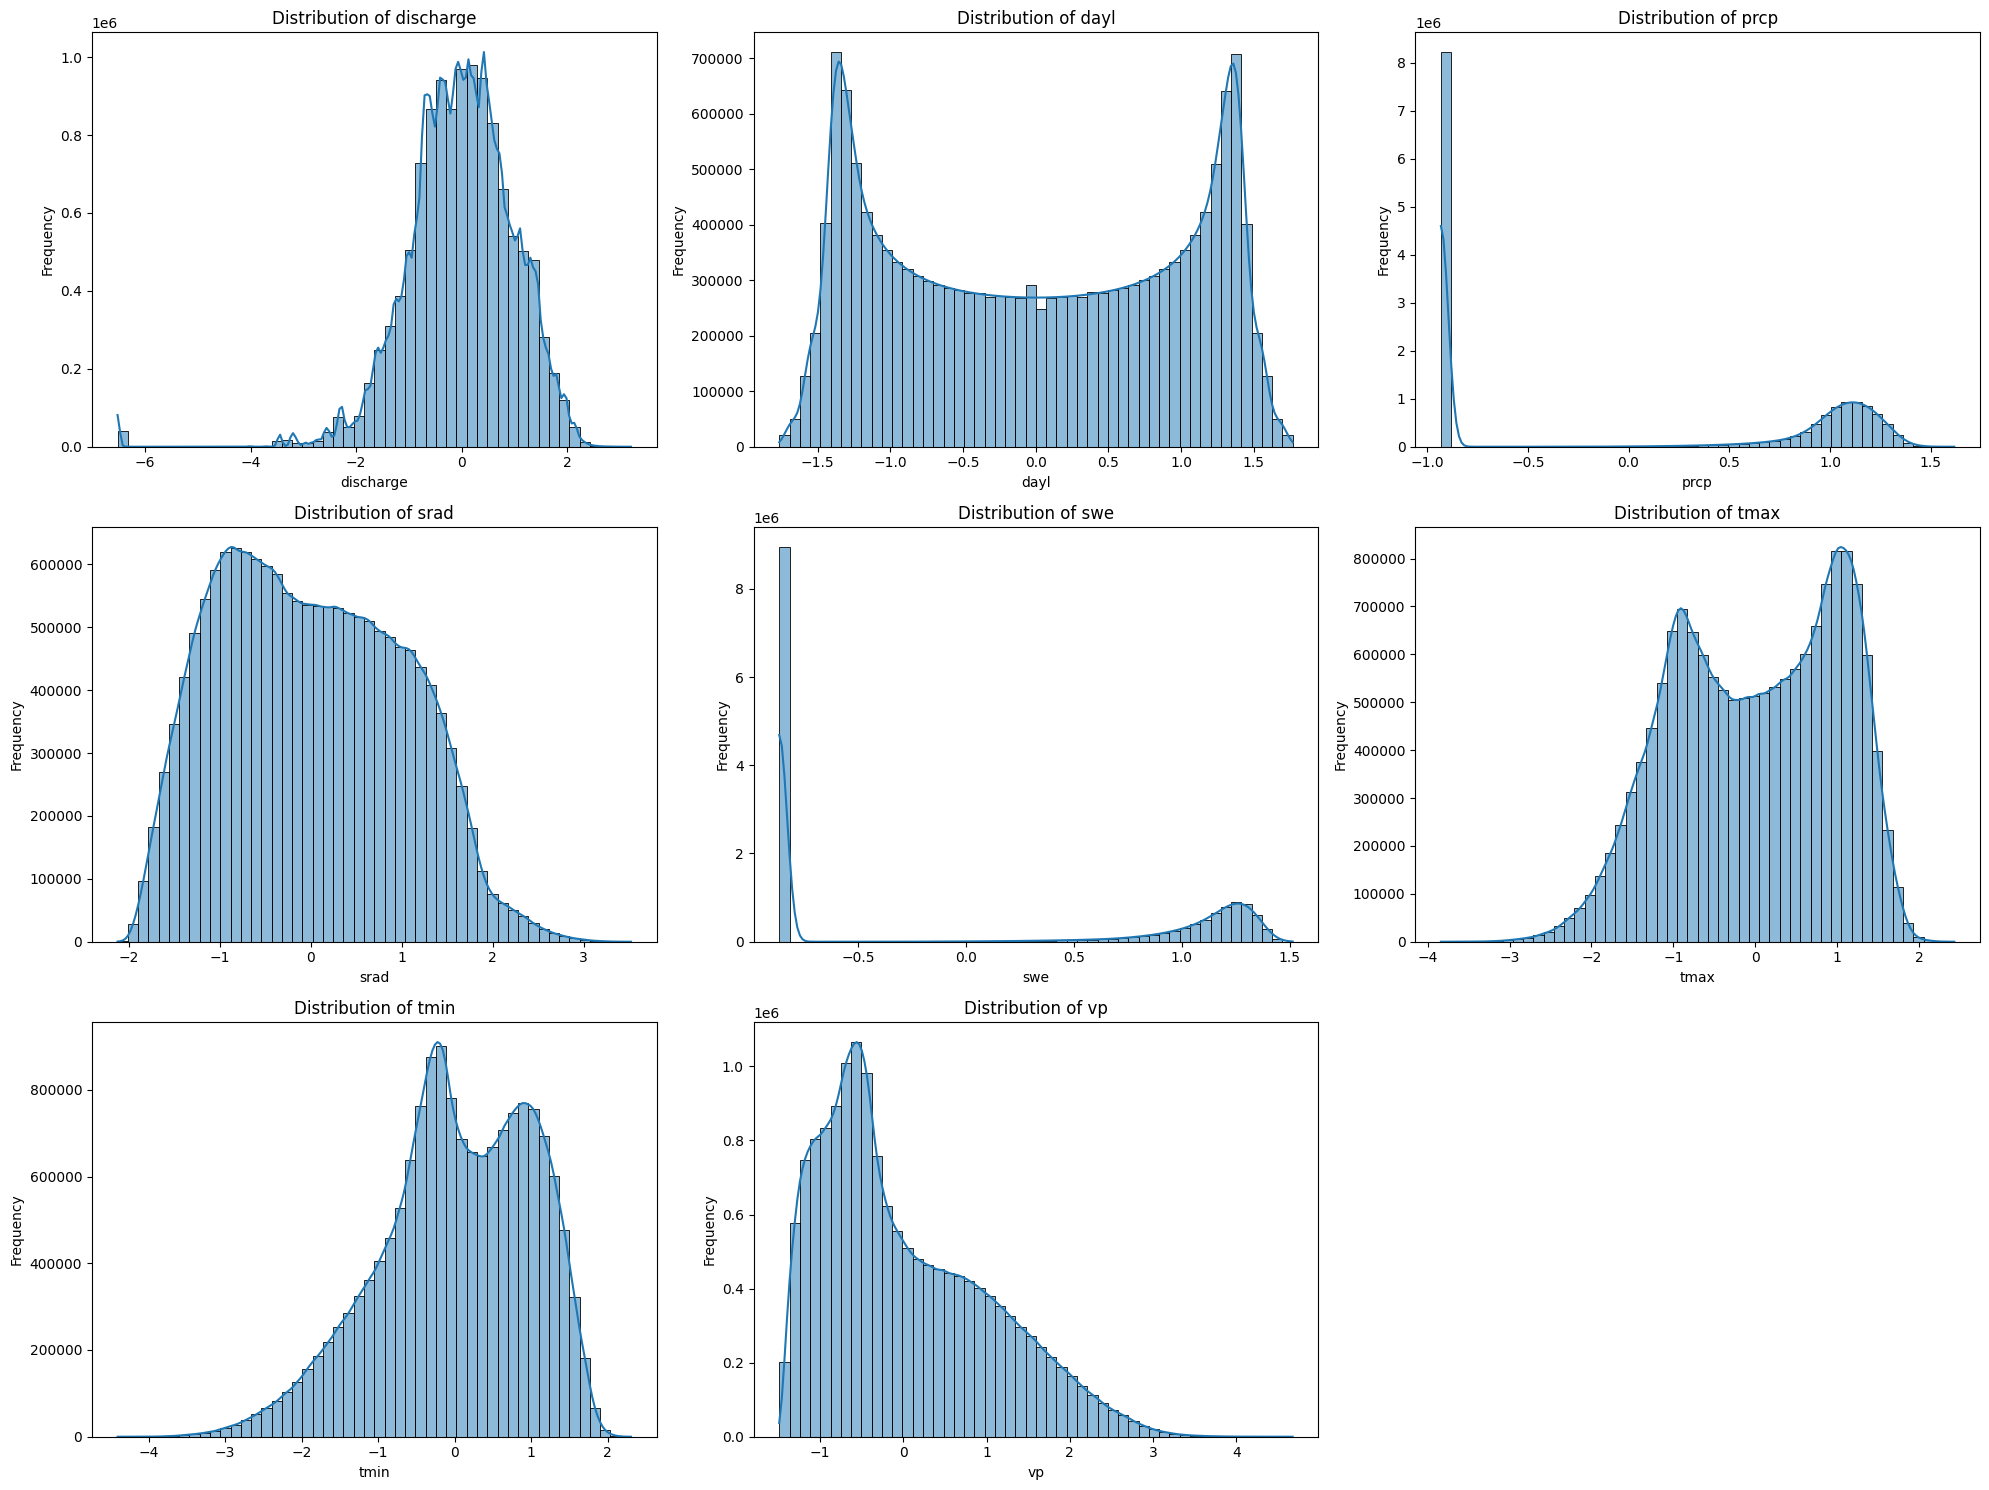

In [6]:
# Plot the distribution of each variable
variables = ['discharge', 'dayl', 'prcp', 'srad', 'swe', 'tmax', 'tmin', 'vp']

plt.figure(figsize=(20, 15))
for i, variable in tqdm(enumerate(variables, 1)):
    plt.subplot(3, 3, i)
    sns.histplot(combined_df[variable].dropna(), bins=50, kde=True)
    plt.xlabel(variable)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {variable}')

plt.tight_layout()
plt.show()

In [5]:
static_attributes = pd.read_csv(r"data/attributes/attributes.csv")
static_attributes.gauge_id

0      3115973
1      4014500
2      4015330
3      4015500
4      4016000
        ...   
434    4257000
435    4258000
436    4260500
437    4263000
438    5535070
Name: gauge_id, Length: 439, dtype: int64

In [6]:
import xarray as xr
import pandas as pd

def read_CDF(file_path: str) -> pd.DataFrame:
    """
    Reads a NetCDF file and converts it back to a pandas DataFrame.
    
    Parameters
    ----------
    file_path : str
        The path to the NetCDF file.
    
    Returns
    ----------
    pd.DataFrame
        A DataFrame containing the data from the NetCDF file.
    """
    ds = xr.open_dataset(file_path)
    return ds.to_dataframe()

df = read_CDF("data/time_series/04015330.nc")

In [9]:
df_filtered = df.loc['1980-01-01':'2022-12-31']
df_filtered['discharge'].describe()

count    15706.000000
mean         2.557595
std          6.354716
min          0.000000
25%          0.282599
50%          0.625796
75%          1.925527
max        336.967294
Name: discharge, dtype: float64

In [10]:
df_filtered

,discharge,dayl,prcp,srad,swe,tmax,tmin,vp
date,,,,,,,,
1980-01-01,0.158573,30175.646,0.000000,100.315250,14.716269,-2.309127,-8.338492,326.26688
1980-01-02,0.152910,30231.023,0.000000,124.818450,14.716269,-6.187183,-13.809524,210.77678
1980-01-03,0.150078,30290.906,0.000000,140.948010,14.716269,-6.173492,-15.020317,191.15907
1980-01-04,0.147246,30355.234,0.000000,117.839554,14.716269,-6.168135,-13.174762,221.82878
1980-01-05,0.141583,30423.960,0.000000,120.697780,14.716269,-4.560317,-11.762540,249.23695
...,...,...,...,...,...,...,...,...
2022-12-27,0.512530,29967.656,0.000000,177.986110,25.550316,-6.892659,-17.697342,152.18250
2022-12-28,0.560668,29999.885,0.000000,145.533050,25.550316,-2.399841,-10.013095,285.72240
2022-12-29,0.628628,30036.800,0.100476,113.221940,24.979008,0.960595,-4.639206,433.48172


In [12]:
import os
import pandas as pd
import numpy as np

def get_file_name(basin_id: str):
    file_name = str(basin_id) + ".csv"
    return "data/z-standardized_csv_files/" + file_name 

def add_date_features(df):
    df.index = pd.to_datetime(df.index)
    df["day_of_week"] = df.index.dayofweek        # 0-6
    df["day_of_month"] = df.index.day - 1           # 0-30
    df["day_of_year"] = df.index.dayofyear - 1        # 0-365
    df["week_of_year"] = df.index.isocalendar().week.astype(int) - 1
    df["month_of_year"] = df.index.month - 1         # 0-11
    date_features = [
        ("day_of_week", 7),
        ("day_of_month", 30.5),
        ("day_of_year", 365),
        ("week_of_year", 52),
        ("month_of_year", 12)
    ]
    for feat, period in date_features:
        df[f"{feat}_sin"] = np.sin(2 * np.pi * df[feat] / (period - 1))
        df[f"{feat}_cos"] = np.cos(2 * np.pi * df[feat] / (period - 1))
    return df

# Folder containing the CSV files
folder_path = "data/z-standardized_csv_files/"

# Iterate over all CSV files in the folder
for file_name in tqdm(os.listdir(folder_path)):
    if file_name.endswith(".csv"):
        file_path = os.path.join(folder_path, file_name)
        
        # Read the CSV file with "date" as an index
        df = pd.read_csv(file_path, index_col='date', parse_dates=True)
        
        # Add date features to the dataframe
        df = add_date_features(df)
        
        # Overwrite the CSV file with the updated dataframe
        df.to_csv(file_path)

print("Date features added and CSV files updated successfully.")

100%|██████████| 976/976 [03:31<00:00,  4.60it/s]

Date features added and CSV files updated successfully.


In [11]:
import os
import pandas as pd
from tqdm import tqdm

# Folder containing the CSV files
folder_path = "data/z-standardized_csv_files/"

# List of date feature columns to remove
date_feature_columns = [
    "day_of_week", "day_of_month", "day_of_year", "week_of_year", "month_of_year",
    "day_of_week_sin", "day_of_week_cos",
    "day_of_month_sin", "day_of_month_cos",
    "day_of_year_sin", "day_of_year_cos",
    "week_of_year_sin", "week_of_year_cos",
    "month_of_year_sin", "month_of_year_cos"
]

# Iterate over all CSV files in the folder
for file_name in tqdm(os.listdir(folder_path)):
    if file_name.endswith(".csv"):
        file_path = os.path.join(folder_path, file_name)
        
        # Read the CSV file with "date" as an index
        df = pd.read_csv(file_path, index_col='date', parse_dates=True)
        
        # Remove the date feature columns from the dataframe
        df.drop(columns=date_feature_columns, inplace=True, errors='ignore')
        
        # Overwrite the CSV file with the cleaned dataframe
        df.to_csv(file_path)

print("Date features removed and CSV files updated successfully.")

 13%|█▎        | 123/976 [00:16<01:52,  7.60it/s]


KeyboardInterrupt: 

# Basin Data Preprocessing with Normalization w.r.t Basin Area

- 2025-06-10

In [4]:
import pandas as pd
import numpy as np
import xarray as xr
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# --- Configuration ---
ATTRIBUTES_FILE = '../metadata/attributes.csv'
INPUT_CSV_DIR = '../metadata/csv_filtered'
OUTPUT_NC_DIR = '../data/time_series'

# Ensure output directory exists
os.makedirs(OUTPUT_NC_DIR, exist_ok=True)

# Variables to log transform
LOG_TRANSFORM_VARS = ['discharge', 'prcp', 'swe']
EPSILON = 1e-6  # Small constant to avoid log(0)
BASIN_AREA_SCALE_DIVISOR = 1000.0 # Factor to divide basin_area by

# Variables to normalize globally (after log transformation for relevant ones)
# 'discharge' here will be the area-normalized and then log-transformed discharge
NORMALIZE_VARS = ['discharge', 'dayl', 'prcp', 'srad', 'swe', 'tmax', 'tmin', 'vp']

In [2]:
# --- 1. Load attributes ---
try:
    attributes_df = pd.read_csv(ATTRIBUTES_FILE)
    # Use gauge_id as index for easy lookup
    attributes_df.set_index('gauge_id', inplace=True)
    print(f"Successfully loaded attributes from '{ATTRIBUTES_FILE}'")
except FileNotFoundError:
    print(f"Error: Attributes file '{ATTRIBUTES_FILE}' not found. Please check the path.")
except KeyError:
    print(f"Error: 'gauge_id' column not found in '{ATTRIBUTES_FILE}'.")

Successfully loaded attributes from '../metadata/attributes.csv'


In [7]:
# --- 2. & 3. Iterate, load, normalize discharge by area, and collect data ---
import warnings

basin_csv_files = glob.glob(os.path.join(INPUT_CSV_DIR, "*.csv"))
if not basin_csv_files:
    print(f"Error: No CSV files found in '{INPUT_CSV_DIR}'. Please check the path.")
    # Consider how to handle this: exit() or allow continuation if some parts can run


all_area_normalized_discharge_values = []
processed_data_for_log_transform = [] # List to store (gauge_id, df) tuples

# Data for the new scatter plot
scatter_plot_basin_areas = []
scatter_plot_mean_original_discharges = []

print(f"\n--- Pass 1: Loading basins, calculating mean original discharge, and preparing for area normalization ---")

warnings.filterwarnings('ignore', category=FutureWarning, message="A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.")
warnings.filterwarnings('ignore', category=RuntimeWarning, message="Mean of empty slice")


for csv_file_path in tqdm(basin_csv_files):
    gauge_id_with_extension = os.path.basename(csv_file_path)
    gauge_id = gauge_id_with_extension.replace('.csv', '')
    # print(f"Processing {gauge_id}...")

    try:
        basin_area = attributes_df.loc[gauge_id, 'area']
    except KeyError:
        print(f"  Warning: gauge_id '{gauge_id}' not found in attributes.csv. Skipping this basin.")
        continue

    if pd.isna(basin_area) or basin_area <= 0:
        print(f"  Warning: Area for {gauge_id} is {basin_area}. Skipping this basin due to invalid area.")
        continue

    # Load basin time series data
    try:
        df_original = pd.read_csv(csv_file_path) # Load fresh copy for original discharge
    except Exception as e:
        print(f"  Error loading CSV {csv_file_path}: {e}. Skipping.")
        continue

    if 'date' not in df_original.columns:
        print(f"  Warning: 'date' column not found in {gauge_id} for {csv_file_path}. Skipping.")
        # continue # If date is essential, uncomment to skip
    else:
        # This conversion is for the df that will be processed later
        # df_original['date'] = pd.to_datetime(df_original['date']) # Not strictly needed for mean discharge
        pass


    # --- Collect data for scatter plot (original mean discharge vs area) ---
    if 'discharge' in df_original.columns:
        mean_discharge_val = df_original['discharge'].mean()
        if pd.notna(mean_discharge_val) and pd.notna(basin_area):
            scatter_plot_basin_areas.append(basin_area)
            scatter_plot_mean_original_discharges.append(mean_discharge_val)
        # else:
            # print(f"  Note: Mean discharge or area is NaN for {gauge_id}. Not adding to scatter plot data.")
    # else:
        # print(f"  Note: 'discharge' column not found in {gauge_id} for scatter plot data collection.")
    
    # --- Now proceed with the main processing pipeline using a fresh or copied df ---
    # It's safer to re-read or deepcopy if df_original was modified or if there's complex logic.
    # For this flow, df_original was only used for .mean(), so we can reuse it as 'df'
    df = df_original 

    if 'date' in df.columns: # Ensure date conversion for the main pipeline df
        df['date'] = pd.to_datetime(df['date'])
    # else: already handled above, decide if critical to continue

    if 'discharge' not in df.columns:
        print(f"  Warning: 'discharge' column not found in {gauge_id} for main processing. Skipping main processing for this basin.")
        continue # Skip main processing steps if discharge is missing

    # Handle missing discharge values for main processing
    df['discharge'] = df['discharge'].fillna(0.0) # Avoid inplace=True

    # Calculate scaled basin area
    scaled_basin_area = basin_area / BASIN_AREA_SCALE_DIVISOR

    # Normalize discharge by scaled basin area for main processing
    if scaled_basin_area == 0:
        print(f"  Warning: Scaled basin area is 0 for {gauge_id} (original area: {basin_area}). Skipping discharge normalization to avoid division by zero.")
        # Decide how to handle df['discharge'] here - perhaps set to NaN or skip appending this df
        # For now, we'll proceed, and it might result in NaNs/Infs if not handled before log
    else:
        df['discharge'] = df['discharge'] / scaled_basin_area

    # Collect area-normalized (and now scaled) discharge values for the distribution plot
    all_area_normalized_discharge_values.extend(df['discharge'].dropna().tolist())

    processed_data_for_log_transform.append({'gauge_id': gauge_id, 'df': df.copy()})

if not processed_data_for_log_transform:
    print("No basin data was successfully processed in the first pass for the main pipeline.")



--- Pass 1: Loading basins, calculating mean original discharge, and preparing for area normalization ---


100%|██████████| 976/976 [00:13<00:00, 70.00it/s]



--- Plotting Scatter: Mean Original Discharge vs. Basin Area ---


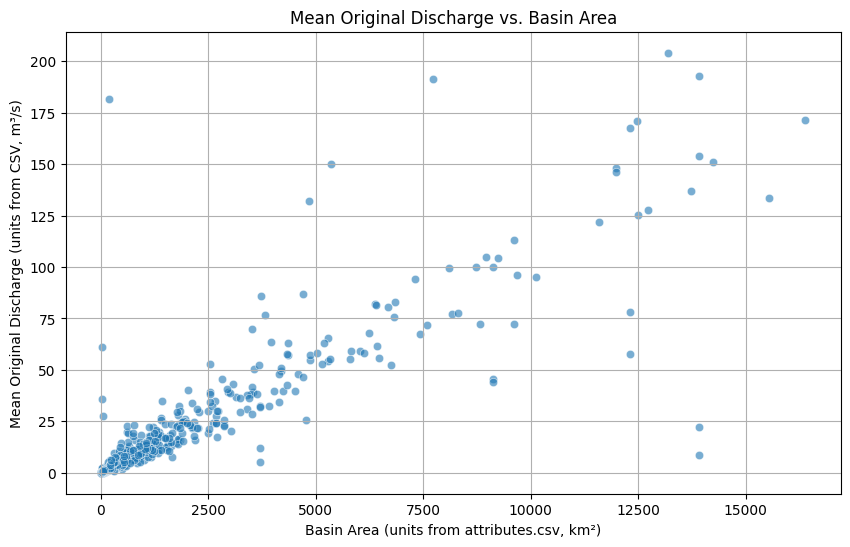

In [5]:
# --- Scatter Plot: Mean Original Discharge vs. Basin Area ---
print(f"\n--- Plotting Scatter: Mean Original Discharge vs. Basin Area ---")
if scatter_plot_basin_areas and scatter_plot_mean_original_discharges:
    plt.figure(figsize=(10, 6))
    plt.scatter(scatter_plot_basin_areas, scatter_plot_mean_original_discharges, alpha=0.6, edgecolors='w', linewidth=0.5)
    plt.title('Mean Original Discharge vs. Basin Area')
    plt.xlabel(f"Basin Area (units from attributes.csv, km²)")
    plt.ylabel('Mean Original Discharge (units from CSV, m³/s)')
    plt.grid(True)
    
    # Optional: Add log scales if the data is highly skewed, which is common for area and discharge
    # plt.xscale('log')
    # plt.yscale('log')
    
    plt.show()
else:
    print("No data available to plot mean original discharge vs. basin area. Check warnings from Pass 1.")


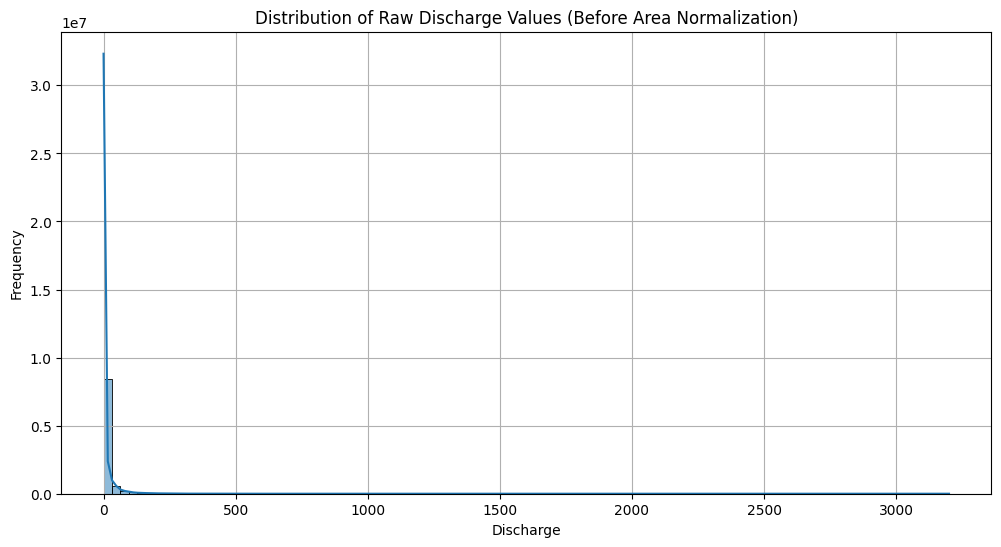

In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Directory containing the original CSV files (before area normalization)
data_folder = '../metadata/csv_filtered'  # Adjust if your raw files are elsewhere

all_discharge = []

for file_name in os.listdir(data_folder):
    if file_name.endswith('.csv'):
        file_path = os.path.join(data_folder, file_name)
        df = pd.read_csv(file_path)
        if 'discharge' in df.columns:
            all_discharge.extend(df['discharge'].dropna().tolist())

plt.figure(figsize=(12, 6))
sns.histplot(all_discharge, bins=100, kde=True)
plt.title('Distribution of Raw Discharge Values (Before Area Normalization)')
plt.xlabel('Discharge')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [12]:
all_discharge_series = pd.Series(all_discharge)
print(all_discharge_series.describe())

count    9.477673e+06
mean     1.447526e+01
std      3.899626e+01
min      0.000000e+00
25%      6.399547e-01
50%      2.630000e+00
75%      1.060000e+01
max      3.199773e+03
dtype: float64


In [15]:
scatter_plot_basin_areas_series = pd.Series(scatter_plot_basin_areas)
print(scatter_plot_basin_areas_series.describe())

count      858.000000
mean      1234.288044
std       2450.373229
min          4.070989
25%         91.115033
50%        303.776839
75%       1074.544698
max      16387.626962
dtype: float64



--- Plotting distribution of area-normalized discharge ---


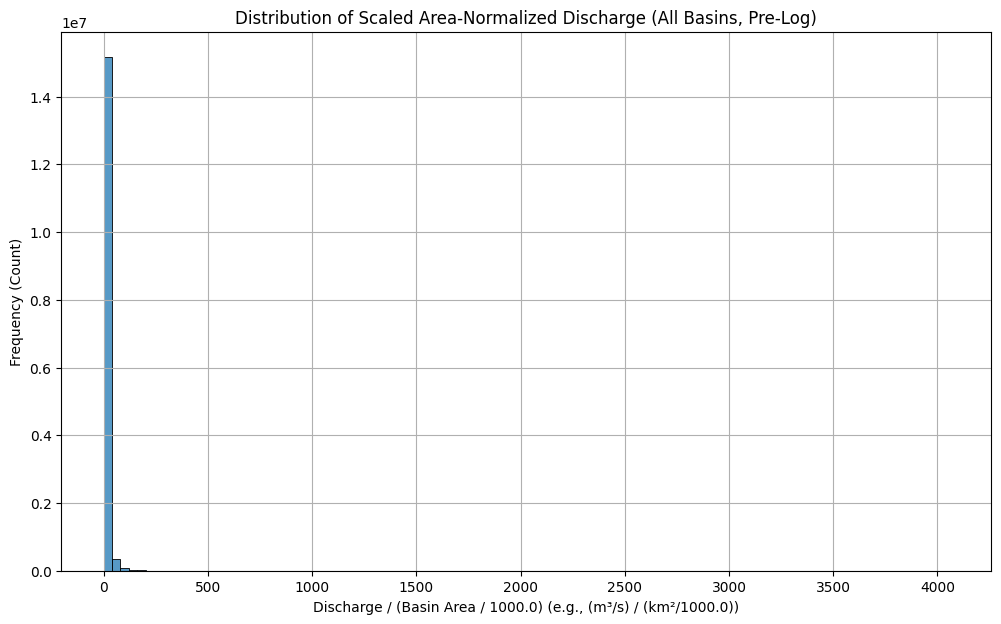


--- Summary Statistics for Area-Normalized Discharge (All Basins, Pre-Log) ---
count    1.566922e+07
mean     1.094590e+01
std      8.272340e+01
min      0.000000e+00
25%      0.000000e+00
50%      2.657637e+00
75%      9.197629e+00
max      4.055208e+03
dtype: float64

Percentiles:
1st: 0.000000
5th: 0.000000
10th: 0.000000
90th: 19.349596
95th: 31.105380
99th: 84.002870


In [8]:
# --- 4. Plot distribution of cumulative (area-normalized) discharge values ---
print(f"\n--- Plotting distribution of area-normalized discharge ---")
if all_area_normalized_discharge_values:
    plt.figure(figsize=(12, 7)) # Adjusted size for better viewing
    sns.histplot(all_area_normalized_discharge_values, bins=100, kde=False) # Changed to regular histogram
    plt.title('Distribution of Scaled Area-Normalized Discharge (All Basins, Pre-Log)')
    plt.xlabel(f'Discharge / (Basin Area / {BASIN_AREA_SCALE_DIVISOR}) (e.g., (m³/s) / (km²/{BASIN_AREA_SCALE_DIVISOR}))')
    plt.ylabel('Frequency (Count)')
    plt.grid(True)
    plt.show() # Display plot in the notebook

    # Print summary statistics
    print("\n--- Summary Statistics for Area-Normalized Discharge (All Basins, Pre-Log) ---")
    discharge_series = pd.Series(all_area_normalized_discharge_values)
    print(discharge_series.describe())
    # You might want to see specific quantiles too
    print("\nPercentiles:")
    print(f"1st: {discharge_series.quantile(0.01):.6f}")
    print(f"5th: {discharge_series.quantile(0.05):.6f}")
    print(f"10th: {discharge_series.quantile(0.1):.6f}")
    print(f"90th: {discharge_series.quantile(0.9):.6f}")
    print(f"95th: {discharge_series.quantile(0.95):.6f}")
    print(f"99th: {discharge_series.quantile(0.99):.6f}")

else:
    print("No discharge data available to plot or calculate statistics.")


In [29]:
# --- 5. Apply log transformation ---
print(f"\n--- Pass 2: Applying log transformations ---")
data_for_global_stats_calc = []
for basin_data in tqdm(processed_data_for_log_transform):
    df = basin_data['df']
    gauge_id = basin_data['gauge_id']
    # print(f"Log-transforming data for {gauge_id}...")
    for col in LOG_TRANSFORM_VARS:
        if col in df.columns:
            # Fill NaNs in prcp and swe with 0 before log, as discharge was already handled
            if col in ['prcp', 'swe']:
                df[col].fillna(0.0, inplace=True)
            df[col] = np.log(df[col] + EPSILON)
        else:
            print(f"  Warning: Column '{col}' for log transformation not found in {gauge_id}.")
    data_for_global_stats_calc.append(df) # Add the modified DataFrame


--- Pass 2: Applying log transformations ---


100%|██████████| 976/976 [00:00<00:00, 1204.02it/s]


In [30]:
# --- 6. Calculate global mean and variance (std dev) ---
print(f"\n--- Calculating global statistics for normalization ---")
if not data_for_global_stats_calc:
    print("No data available for global statistics calculation. Exiting.")
    exit()

combined_df_for_stats = pd.concat(data_for_global_stats_calc, ignore_index=True)

global_means = {}
global_stds = {}

for var in NORMALIZE_VARS:
    if var in combined_df_for_stats.columns:
        global_means[var] = combined_df_for_stats[var].mean()
        global_stds[var] = combined_df_for_stats[var].std()
        # Handle cases where std might be 0 (e.g., if a variable is constant)
        if global_stds[var] == 0:
            print(f"  Warning: Global standard deviation for '{var}' is 0. Using 1.0 to avoid division by zero.")
            global_stds[var] = 1.0
        print(f"  Global mean for {var}: {global_means[var]:.4f}, Global std for {var}: {global_stds[var]:.4f}")
    else:
        print(f"  Warning: Variable '{var}' for normalization not found in combined data. Will not be normalized.")


--- Calculating global statistics for normalization ---


C:\Users\ybrot\AppData\Local\Temp\ipykernel_15656\3464053214.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df_for_stats = pd.concat(data_for_global_stats_calc, ignore_index=True)


  Global mean for discharge: -5.6812, Global std for discharge: 6.6487
  Global mean for dayl: 43192.0860, Global std for dayl: 8322.4514
  Global mean for prcp: -6.7703, Global std for prcp: 7.4765
  Global mean for srad: 297.3089, Global std for srad: 133.7095
  Global mean for swe: -6.5171, Global std for swe: 8.5202
  Global mean for tmax: 12.0944, Global std for tmax: 11.7797
  Global mean for tmin: 1.6368, Global std for tmin: 10.8173
  Global mean for vp: 852.6610, Global std for vp: 562.9347


In [31]:
processed_data_for_log_transform

[{'gauge_id': '02AA001',
  'df':             date  discharge       dayl       prcp        srad       swe  \
  0     1980-01-01  -1.911505  29643.209 -13.815511  134.001530  4.418324   
  1     1980-01-02  -1.911505  29701.252 -13.815511  161.916260  4.418324   
  2     1980-01-03  -1.911505  29764.002 -13.815511  181.165300  4.418324   
  3     1980-01-04  -1.898657  29831.414   1.369733  109.064450  4.464660   
  4     1980-01-05  -1.898657  29903.428   2.329042   75.106310  4.576355   
  ...          ...        ...        ...        ...         ...       ...   
  16066 2023-12-27 -13.815511  29425.148  -0.201521   44.535780 -4.595687   
  16067 2023-12-28 -13.815511  29458.941 -13.815511   84.713974 -4.979547   
  16068 2023-12-29 -13.815511  29497.648 -13.815511  141.090930 -4.979547   
  16069 2023-12-30 -13.815511  29541.252   0.772460   87.345980  0.759645   
  16070 2023-12-31 -13.815511  29589.705 -13.815511   95.847534  0.759645   
  
             tmax       tmin          vp  

In [32]:

# --- 7. Normalize with global stats and save to NetCDF ---
print(f"\n--- Pass 3: Normalizing with global stats and saving to NetCDF ---")
# We need to iterate through `processed_data_for_log_transform` again because
# `data_for_global_stats_calc` is a list of DFs, and we need the gauge_id.
# The DFs inside `processed_data_for_log_transform` were modified in-place during log transform.

for basin_data_dict in tqdm(processed_data_for_log_transform):
    gauge_id = basin_data_dict['gauge_id']
    df_basin = basin_data_dict['df'] # This df has already been log-transformed where applicable
    # print(f"Normalizing and saving {gauge_id}...")

    for var in NORMALIZE_VARS:
        if var in df_basin.columns and var in global_means and var in global_stds:
            df_basin[var] = (df_basin[var] - global_means[var]) / global_stds[var]
        elif var in df_basin.columns:
            print(f"  Skipping normalization for '{var}' in {gauge_id} as global stats were not available.")

    # Set date as index for xarray conversion
    if 'date' in df_basin.columns:
        df_basin.set_index('date', inplace=True)
    else:
        print(f"  Error: 'date' column missing before xarray conversion for {gauge_id}. Skipping NetCDF save.")
        continue

    # Convert to xarray Dataset
    try:
        # df_basin.index.name is 'date' at this point.
        # xr.Dataset.from_dataframe should use this index name for the coordinate.
        xr_dataset = xr.Dataset.from_dataframe(df_basin)
        
        # The following lines that renamed 'date' to 'time' have been removed
        # to ensure the coordinate remains 'date'.
        # # Optional: Rename 'date' index to 'time' if preferred for NetCDF
        # if 'date' in xr_dataset.dims:
        #      xr_dataset = xr_dataset.rename({'date': 'time'})

        # Add some attributes (optional, but good practice)
        xr_dataset.attrs['gauge_id'] = gauge_id
        try:
            # Add other attributes if they exist and are useful
            basin_attrs_series = attributes_df.loc[gauge_id]
            for attr_name, attr_val in basin_attrs_series.items():
                if pd.notna(attr_val): # Only add non-NaN attributes
                    xr_dataset.attrs[attr_name] = attr_val
        except KeyError:
            print(f"  Note: Could not retrieve additional attributes for {gauge_id} for NetCDF metadata.")


        # Save to NetCDF
        output_nc_file = os.path.join(OUTPUT_NC_DIR, f"{gauge_id}.nc")
        xr_dataset.to_netcdf(output_nc_file)
        # print(f"  Successfully saved {output_nc_file}")
    except Exception as e:
        print(f"  Error converting or saving NetCDF for {gauge_id}: {e}")

print("\n--- Preprocessing complete. ---")


--- Pass 3: Normalizing with global stats and saving to NetCDF ---


100%|██████████| 976/976 [00:17<00:00, 55.66it/s]


--- Preprocessing complete. ---


In [35]:
import xarray as xr
import pandas as pd
from pathlib import Path

def inspect_nc_file_structure(file_path: Path, description: str):
    print(f"\n--- Inspecting: {description} ---")
    print(f"File: {file_path}")
    if not file_path.exists():
        print("File does not exist.")
        return None

    try:
        ds = xr.open_dataset(file_path)
        print("\nxarray.Dataset structure:")
        print(ds)
        
        print("\nCoordinates:")
        for coord_name, coord_val in ds.coords.items():
            print(f"  Name: {coord_name}, Dimensions: {coord_val.dims}, Shape: {coord_val.shape}")

        df = ds.to_dataframe()
        print("\nConverted pandas DataFrame info:")
        df.info()
        print(f"DataFrame index name: {df.index.name}")
        ds.close()
        return df
    except Exception as e:
        print(f"Error inspecting file {file_path}: {e}")
        return None

# --- Configuration ---
# Choose a basin_id that exists in both directories for a fair comparison
sample_basin_id = "02AA001" 

path_problematic = Path(f"../data/time_series/{sample_basin_id}.nc")
path_working = Path(f"../data/time_series_gl/{sample_basin_id}.nc")

# Inspect the problematic file type
print("Problematic files are from: ../data/time_series/")
df_problematic = inspect_nc_file_structure(path_problematic, "Problematic Type (from ../data/time_series/)")

# Inspect the working file type
print("\n\nWorking files are from: ../data/time_series_gl/")
df_working = inspect_nc_file_structure(path_working, "Working Type (from ../data/time_series_gl/)")

if df_problematic is not None and df_working is not None:
    print("\n--- Comparison Summary ---")
    print(f"Problematic file ({path_problematic.name}) index name: {df_problematic.index.name}")
    print(f"Working file ({path_working.name}) index name: {df_working.index.name}")
    
    # Further check coordinates if needed by looking at the xarray printout
    # For example, if working files have 'time' and problematic ones have 'index' or None for the time dim.
else:
    print("\nCould not complete comparison due to errors loading one or both files.")


Problematic files are from: ../data/time_series/

--- Inspecting: Problematic Type (from ../data/time_series/) ---
File: ..\data\time_series\02AA001.nc

xarray.Dataset structure:
<xarray.Dataset> Size: 1MB
Dimensions:    (date: 16071)
Coordinates:
  * date       (date) datetime64[ns] 129kB 1980-01-01 1980-01-02 ... 2023-12-31
Data variables:
    discharge  (date) float64 129kB ...
    dayl       (date) float64 129kB ...
    prcp       (date) float64 129kB ...
    srad       (date) float64 129kB ...
    swe        (date) float64 129kB ...
    tmax       (date) float64 129kB ...
    tmin       (date) float64 129kB ...
    vp         (date) float64 129kB ...
Attributes: (12/198)
    gauge_id:                            02AA001
    sgr_dk_sav:                          40.4951747665904
    glc_pc_s06:                          41.129883767232464
    glc_pc_s07:                          0.0
    nli_ix_sav:                          21.45739729333309
    glc_pc_s04:                          7.6

# Basin Data Preprocessing with Improved Normalization Strategy 1: Log-Transform Before Area Normalization

**Date: 2025-01-18**

**Strategy 1: Log-Transform Before Area Normalization**

This section implements the recommended approach to address numerical instability issues identified in the previous normalization strategy. Instead of directly normalizing discharge by basin area (which can create extreme values), we:

1. **First apply log transformation** to discharge to compress the range and stabilize values
2. **Then normalize by (scaled) basin area** to account for basin size differences  
3. **Apply global z-score normalization** for consistent scaling across all variables

**Key Benefits:**
- **Numerical Stability**: Log transformation prevents extreme values from discharge/area normalization
- **Preserved Relationships**: Maintains the relative relationships between discharge and basin characteristics
- **Better Model Performance**: More stable input features for LSTM training
- **Reduced Variance**: Compressed value ranges reduce the risk of gradient explosion/vanishing

**Normalization Order:**
1. Log-transform discharge: `log(discharge + ε)`
2. Area normalization: `log_discharge / (basin_area / scale_factor)`  
3. Global z-score: `(value - global_mean) / global_std`

This approach addresses the extreme values identified in the distribution analysis and provides a more robust preprocessing pipeline for hydrological modeling.

In [ ]:
import pandas as pd
import numpy as np
import xarray as xr
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# --- Configuration for Strategy 1: Log-Transform Before Area Normalization ---
ATTRIBUTES_FILE_S1 = '../metadata/attributes.csv'
INPUT_CSV_DIR_S1 = '../metadata/csv_filtered'
OUTPUT_NC_DIR_S1 = '../data/time_series_strategy1'  # New output directory for this strategy

# Ensure output directory exists
os.makedirs(OUTPUT_NC_DIR_S1, exist_ok=True)

# Variables to log transform BEFORE area normalization (key difference)
LOG_TRANSFORM_VARS_S1 = ['discharge', 'prcp', 'swe']
EPSILON_S1 = 1e-6  # Small constant to avoid log(0)
BASIN_AREA_SCALE_DIVISOR_S1 = 1000.0  # Factor to divide basin_area by

# Variables to normalize globally (after log+area normalization for discharge)
# Note: 'discharge' here will be log-transformed THEN area-normalized
NORMALIZE_VARS_S1 = ['discharge', 'dayl', 'prcp', 'srad', 'swe', 'tmax', 'tmin', 'vp']

print("Configuration for Strategy 1: Log-Transform Before Area Normalization")
print(f"Input CSV Directory: {INPUT_CSV_DIR_S1}")
print(f"Output NetCDF Directory: {OUTPUT_NC_DIR_S1}")
print(f"Basin Area Scale Divisor: {BASIN_AREA_SCALE_DIVISOR_S1}")
print(f"Variables for log transformation: {LOG_TRANSFORM_VARS_S1}")
print(f"Variables for global normalization: {NORMALIZE_VARS_S1}")
print(f"Epsilon for log transform: {EPSILON_S1}")

In [ ]:
# --- 1. Load attributes for Strategy 1 ---
try:
    attributes_df_s1 = pd.read_csv(ATTRIBUTES_FILE_S1)
    # Use gauge_id as index for easy lookup
    attributes_df_s1.set_index('gauge_id', inplace=True)
    print(f"Successfully loaded attributes from '{ATTRIBUTES_FILE_S1}'")
    print(f"Number of basins in attributes: {len(attributes_df_s1)}")
except FileNotFoundError:
    print(f"Error: Attributes file '{ATTRIBUTES_FILE_S1}' not found. Please check the path.")
except KeyError:
    print(f"Error: 'gauge_id' column not found in '{ATTRIBUTES_FILE_S1}'.")

In [ ]:
# --- 2. & 3. Strategy 1: Log-Transform THEN Area Normalize ---
import warnings

basin_csv_files_s1 = glob.glob(os.path.join(INPUT_CSV_DIR_S1, "*.csv"))
if not basin_csv_files_s1:
    print(f"Error: No CSV files found in '{INPUT_CSV_DIR_S1}'. Please check the path.")

all_log_then_area_normalized_discharge_values = []
processed_data_for_global_norm_s1 = []  # List to store processed data

# Data for comparison plots
scatter_plot_basin_areas_s1 = []
scatter_plot_mean_original_discharges_s1 = []
scatter_plot_mean_log_discharges_s1 = []
scatter_plot_mean_log_area_norm_discharges_s1 = []

print(f"\n--- Strategy 1 Pass 1: Log-Transform BEFORE Area Normalization ---")
print("Processing order:")
print("1. Load raw discharge data")
print("2. Apply log transformation: log(discharge + ε)")  
print("3. Apply area normalization: log_discharge / (basin_area / scale_factor)")
print("4. Collect for global normalization")

warnings.filterwarnings('ignore', category=FutureWarning, message="A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.")
warnings.filterwarnings('ignore', category=RuntimeWarning, message="Mean of empty slice")

for csv_file_path in tqdm(basin_csv_files_s1):
    gauge_id_with_extension = os.path.basename(csv_file_path)
    gauge_id = gauge_id_with_extension.replace('.csv', '')

    try:
        basin_area = attributes_df_s1.loc[gauge_id, 'area']
    except KeyError:
        print(f"  Warning: gauge_id '{gauge_id}' not found in attributes.csv. Skipping this basin.")
        continue

    if pd.isna(basin_area) or basin_area <= 0:
        print(f"  Warning: Area for {gauge_id} is {basin_area}. Skipping this basin due to invalid area.")
        continue

    # Load basin time series data
    try:
        df_s1 = pd.read_csv(csv_file_path)
    except Exception as e:
        print(f"  Error loading CSV {csv_file_path}: {e}. Skipping.")
        continue

    if 'date' not in df_s1.columns:
        print(f"  Warning: 'date' column not found in {gauge_id}. Skipping.")
        continue
    
    df_s1['date'] = pd.to_datetime(df_s1['date'])

    if 'discharge' not in df_s1.columns:
        print(f"  Warning: 'discharge' column not found in {gauge_id}. Skipping.")
        continue

    # Store original discharge for comparison
    original_discharge = df_s1['discharge'].copy()
    mean_original_discharge = original_discharge.mean()
    
    # Handle missing discharge values
    df_s1['discharge'] = df_s1['discharge'].fillna(0.0)
    
    # === STRATEGY 1: LOG TRANSFORM FIRST ===
    # Step 1: Apply log transformation to discharge BEFORE area normalization
    df_s1['discharge'] = np.log(df_s1['discharge'] + EPSILON_S1)
    mean_log_discharge = df_s1['discharge'].mean()
    
    # Step 2: THEN apply area normalization to the log-transformed discharge
    scaled_basin_area = basin_area / BASIN_AREA_SCALE_DIVISOR_S1
    
    if scaled_basin_area == 0:
        print(f"  Warning: Scaled basin area is 0 for {gauge_id} (original area: {basin_area}). Skipping.")
        continue
    
    df_s1['discharge'] = df_s1['discharge'] / scaled_basin_area
    mean_log_area_norm_discharge = df_s1['discharge'].mean()
    
    # Log transform other variables as well
    for col in LOG_TRANSFORM_VARS_S1:
        if col != 'discharge' and col in df_s1.columns:  # discharge already transformed
            if col in ['prcp', 'swe']:
                df_s1[col].fillna(0.0, inplace=True)
            df_s1[col] = np.log(df_s1[col] + EPSILON_S1)

    # Collect data for plots and analysis
    if pd.notna(mean_original_discharge) and pd.notna(basin_area):
        scatter_plot_basin_areas_s1.append(basin_area)
        scatter_plot_mean_original_discharges_s1.append(mean_original_discharge)
        scatter_plot_mean_log_discharges_s1.append(mean_log_discharge)
        scatter_plot_mean_log_area_norm_discharges_s1.append(mean_log_area_norm_discharge)

    # Collect log-then-area-normalized discharge values for distribution analysis
    all_log_then_area_normalized_discharge_values.extend(df_s1['discharge'].dropna().tolist())

    processed_data_for_global_norm_s1.append({'gauge_id': gauge_id, 'df': df_s1.copy()})

print(f"\nStrategy 1 completed. Processed {len(processed_data_for_global_norm_s1)} basins.")
if not processed_data_for_global_norm_s1:
    print("No basin data was successfully processed in Strategy 1.")

In [ ]:
# --- Strategy 1 Visualization: Compare Discharge Transformations ---
print(f"\n--- Strategy 1: Visualization of Discharge Transformations ---")

if (scatter_plot_basin_areas_s1 and scatter_plot_mean_original_discharges_s1 and 
    scatter_plot_mean_log_discharges_s1 and scatter_plot_mean_log_area_norm_discharges_s1):
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Original Discharge vs Basin Area
    axes[0, 0].scatter(scatter_plot_basin_areas_s1, scatter_plot_mean_original_discharges_s1, 
                      alpha=0.6, edgecolors='w', linewidth=0.5, color='blue')
    axes[0, 0].set_title('Original Discharge vs Basin Area')
    axes[0, 0].set_xlabel('Basin Area (km²)')
    axes[0, 0].set_ylabel('Mean Original Discharge (m³/s)')
    axes[0, 0].grid(True)
    
    # Plot 2: Log-Transformed Discharge vs Basin Area  
    axes[0, 1].scatter(scatter_plot_basin_areas_s1, scatter_plot_mean_log_discharges_s1, 
                      alpha=0.6, edgecolors='w', linewidth=0.5, color='green')
    axes[0, 1].set_title('Log-Transformed Discharge vs Basin Area')
    axes[0, 1].set_xlabel('Basin Area (km²)')
    axes[0, 1].set_ylabel('Mean Log(Discharge + ε)')
    axes[0, 1].grid(True)
    
    # Plot 3: Log+Area-Normalized Discharge vs Basin Area
    axes[1, 0].scatter(scatter_plot_basin_areas_s1, scatter_plot_mean_log_area_norm_discharges_s1, 
                      alpha=0.6, edgecolors='w', linewidth=0.5, color='red')
    axes[1, 0].set_title('Log+Area-Normalized Discharge vs Basin Area')
    axes[1, 0].set_xlabel('Basin Area (km²)')
    axes[1, 0].set_ylabel(f'Mean Log(Discharge)/Area*{BASIN_AREA_SCALE_DIVISOR_S1}')
    axes[1, 0].grid(True)
    
    # Plot 4: Distribution of Final Normalized Discharge
    axes[1, 1].hist(all_log_then_area_normalized_discharge_values, bins=100, alpha=0.7, color='purple')
    axes[1, 1].set_title('Distribution: Log+Area-Normalized Discharge')
    axes[1, 1].set_xlabel('Log(Discharge)/Scaled_Area')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n--- Strategy 1 Summary Statistics ---")
    original_stats = pd.Series(scatter_plot_mean_original_discharges_s1)
    log_stats = pd.Series(scatter_plot_mean_log_discharges_s1)
    log_area_stats = pd.Series(scatter_plot_mean_log_area_norm_discharges_s1)
    
    print("Original Discharge:")
    print(original_stats.describe())
    print("\nLog-Transformed Discharge:")  
    print(log_stats.describe())
    print("\nLog+Area-Normalized Discharge:")
    print(log_area_stats.describe())
    
else:
    print("No data available for Strategy 1 visualizations.")

In [ ]:
# --- Strategy Comparison: Distribution Analysis ---
print(f"\n--- Comparing Distributions: Original Strategy vs Strategy 1 ---")

if all_log_then_area_normalized_discharge_values and all_area_normalized_discharge_values:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Original Strategy: Area normalization THEN log transform
    axes[0].hist(all_area_normalized_discharge_values, bins=100, alpha=0.7, color='orange', edgecolor='black')
    axes[0].set_title('Original Strategy:\nArea Normalization → Log Transform')
    axes[0].set_xlabel('Discharge / Scaled_Area (Pre-Log)')
    axes[0].set_ylabel('Frequency')
    axes[0].grid(True)
    
    # Strategy 1: Log transform THEN area normalization  
    axes[1].hist(all_log_then_area_normalized_discharge_values, bins=100, alpha=0.7, color='purple', edgecolor='black')
    axes[1].set_title('Strategy 1 (Improved):\nLog Transform → Area Normalization') 
    axes[1].set_xlabel('Log(Discharge) / Scaled_Area')
    axes[1].set_ylabel('Frequency')
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Statistical comparison
    print("\n--- Statistical Comparison ---")
    original_series = pd.Series(all_area_normalized_discharge_values)
    strategy1_series = pd.Series(all_log_then_area_normalized_discharge_values)
    
    print("Original Strategy (Area → Log):")
    print(f"  Mean: {original_series.mean():.4f}")
    print(f"  Std:  {original_series.std():.4f}")
    print(f"  Min:  {original_series.min():.4f}")
    print(f"  Max:  {original_series.max():.4f}")
    print(f"  Range: {original_series.max() - original_series.min():.4f}")
    
    print("\nStrategy 1 (Log → Area):")  
    print(f"  Mean: {strategy1_series.mean():.4f}")
    print(f"  Std:  {strategy1_series.std():.4f}")
    print(f"  Min:  {strategy1_series.min():.4f}")
    print(f"  Max:  {strategy1_series.max():.4f}")
    print(f"  Range: {strategy1_series.max() - strategy1_series.min():.4f}")
    
    # Check for extreme values
    print(f"\n--- Extreme Value Analysis ---")
    original_q99 = original_series.quantile(0.99)
    original_q01 = original_series.quantile(0.01)
    strategy1_q99 = strategy1_series.quantile(0.99)
    strategy1_q01 = strategy1_series.quantile(0.01)
    
    print(f"Original Strategy - 99th percentile: {original_q99:.4f}")
    print(f"Original Strategy - 1st percentile:  {original_q01:.4f}")
    print(f"Strategy 1 - 99th percentile: {strategy1_q99:.4f}")
    print(f"Strategy 1 - 1st percentile:  {strategy1_q01:.4f}")
    
    range_reduction = ((original_series.max() - original_series.min()) - 
                      (strategy1_series.max() - strategy1_series.min())) / (original_series.max() - original_series.min()) * 100
    print(f"\nRange reduction with Strategy 1: {range_reduction:.1f}%")
    
else:
    print("Cannot compare distributions - data missing from one or both strategies.")